In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
from matplotlib import patches, patheffects
import torch
import numpy as np
from torchvision.utils import draw_bounding_boxes

In [3]:
path = untar_data(URLs.PASCAL_2012)

In [4]:
path.ls()

(#6) [Path('/home/ubuntu/.fastai/data/pascal_2012/valid.json'),Path('/home/ubuntu/.fastai/data/pascal_2012/test'),Path('/home/ubuntu/.fastai/data/pascal_2012/train'),Path('/home/ubuntu/.fastai/data/pascal_2012/train.json'),Path('/home/ubuntu/.fastai/data/pascal_2012/segmentation'),Path('/home/ubuntu/.fastai/data/pascal_2012/train.csv')]

In [5]:
train_imgs = path/'train'
train_imgs.ls()

(#11540) [Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_003773.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_002344.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2010_004371.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2009_005075.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_008429.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2011_001707.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_000723.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2009_005282.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_006793.jpg'),Path('/home/ubuntu/.fastai/data/pascal_2012/train/2008_001969.jpg')...]

In [6]:
import pandas as pd

df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  2008_000002.jpg     tvmonitor      True
1  2008_000003.jpg  train person      True
2  2008_000007.jpg          boat      True
3  2008_000008.jpg  horse person     False
4  2008_000009.jpg           cow      True

In [7]:
imgs, lbl_bbox = get_annotations(path/'train.json') 

In [8]:
lbl_bbox[3], lbl_bbox[3][0], lbl_bbox[3][1][0], lbl_bbox[3][0][0]

(([[5, 0, 314, 262],
   [39, 96, 121, 411],
   [136, 35, 169, 109],
   [179, 35, 216, 104],
   [95, 38, 123, 103]],
  ['tvmonitor', 'bottle', 'person', 'person', 'person']),
 [[5, 0, 314, 262],
  [39, 96, 121, 411],
  [136, 35, 169, 109],
  [179, 35, 216, 104],
  [95, 38, 123, 103]],
 'tvmonitor',
 [5, 0, 314, 262])

In [9]:
img2bbox=collections.defaultdict(lambda:([],[]))
for i in range(len(lbl_bbox)):
    for j in range (len(lbl_bbox[i][1])):
        if lbl_bbox[i][1][j] == 'person':
            img2bbox[imgs[i]][0].append(lbl_bbox[i][0][j])
            img2bbox[imgs[i]][1].append(lbl_bbox[i][1][j])

In [10]:
len(img2bbox.keys())

2142

In [11]:
img2bbox[list(img2bbox.keys())[5]], img2bbox[list(img2bbox.keys())[5]][0], img2bbox[list(img2bbox.keys())[5]][1]

(([[227, 89, 338, 365]], ['person']), [[227, 89, 338, 365]], ['person'])

In [13]:
img2bbox

defaultdict(<function __main__.<lambda>()>,
            {'2008_000008.jpg': ([[157, 43, 289, 167]], ['person']),
             '2008_000023.jpg': ([[136, 35, 169, 109],
               [179, 35, 216, 104],
               [95, 38, 123, 103]],
              ['person', 'person', 'person']),
             '2008_000036.jpg': ([[205, 73, 395, 237]], ['person']),
             '2008_000041.jpg': ([[270, 169, 386, 234],
               [294, 188, 328, 231],
               [205, 175, 256, 236],
               [121, 161, 198, 330],
               [456, 211, 500, 297],
               [437, 172, 500, 243],
               [357, 187, 469, 359]],
              ['person',
               'person',
               'person',
               'person',
               'person',
               'person',
               'person']),
             '2008_000096.jpg': ([[0, 0, 500, 375]], ['person']),
             '2008_000109.jpg': ([[227, 89, 338, 365]], ['person']),
             '2008_000128.jpg': ([[0, 84, 361, 375], 

In [287]:
def bb_hw(b):
    return np.array([b[0], b[3], b[1]-b[3]+1, b[2]-b[0]+1])

def show_img(img, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), 
                        patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], b[3], b[2], fill=False, edgecolor=color, lw=2))

In [288]:
img2bbox[list(img2bbox.keys())[9]][0], torch.tensor(img2bbox[list(img2bbox.keys())[9]][0][0]).reshape(-1,4)

([[92, 158, 105, 188], [35, 99, 129, 333]], tensor([[ 92, 158, 105, 188]]))

[172, 168, 350, 370]
[237, 159, 297, 254]


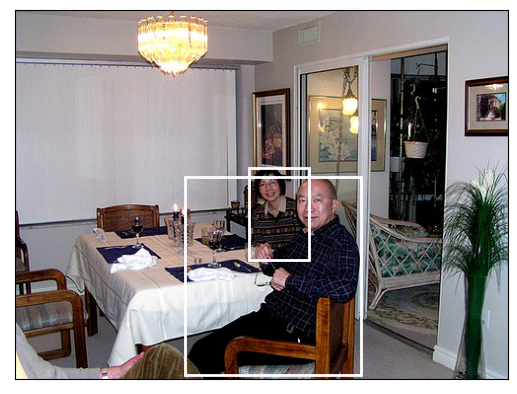

In [289]:
im = Image.open(train_imgs/list(img2bbox.keys())[215])
ax = show_img(im)
for o in img2bbox[list(img2bbox.keys())[215]][0]:
    print(o)
    b = bb_hw(o)
    draw_rect(ax, b)

In [15]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [16]:
item_tfms = [Resize(224, method='squish'),]
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [17]:
db = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [18]:
dls = db.dataloaders(list(img2bbox.keys()), bs = 64)

In [19]:
dls.vocab

['#na#', 'person']

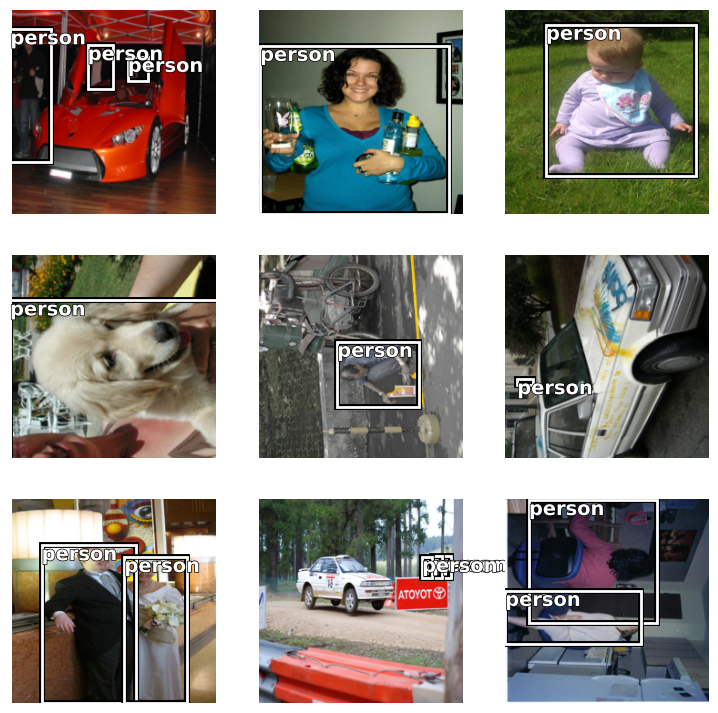

In [20]:
dls.show_batch()

In [21]:
one_batch = dls.one_batch()

In [22]:
one_batch[1][0][0]

TensorBBox([-0.4974, -0.6224, -0.0579,  0.6294])

In [23]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super(StdConv, self).__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

def flatten(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [24]:
x = torch.randn(2,3)
y = torch.transpose(x, 0, 1)
z = torch.transpose(x, 1, 0)
x, y, z

(tensor([[ 0.4891, -0.4461,  0.4520],
         [ 0.0359,  0.2195, -0.7276]]),
 tensor([[ 0.4891,  0.0359],
         [-0.4461,  0.2195],
         [ 0.4520, -0.7276]]),
 tensor([[ 0.4891,  0.0359],
         [-0.4461,  0.2195],
         [ 0.4520, -0.7276]]))

In [25]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super(OutConv, self).__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(dls.vocab))*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten(self.oconv1(x), self.k),
                flatten(self.oconv2(x), self.k)]

In [26]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.1)
        self.sconv0 = StdConv(512, 256, 1)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)

In [27]:
k=1
head_reg4 = SSD_Head(k, -3.)

In [28]:
body = create_body(resnet34(True))
model = nn.Sequential(body, head_reg4)

/home/ubuntu/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/home/ubuntu/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
out0 = body(one_batch[0].cpu())
out1 = head_reg4(out0)

out1[0].shape,out1[1].shape

(torch.Size([64, 16, 2]), torch.Size([64, 16, 4]))

In [84]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

In [199]:
num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [342]:
def torch_gt(ax, ima, bbox, clas, s=True, thresh=0.4):
    ax = show_img(ima, ax=ax)
    if s:
        bb = [bb_hw(to_np((((b+1)/2*224).long()))) for b in bbox]
    else: 
        bb = [bb_hw(to_np(((b*224).long()))) for b in bbox]
    for b1,c in zip(bb,clas):
        draw_rect_batch(ax, b1, color=colr_list[i%num_colr])
        if c==0:
            draw_text(ax, [b1[3],b1[0]], txt="bg",color=colr_list[i%num_colr])
        else:
            draw_text(ax, [b1[3],b1[0]], color=colr_list[i%num_colr])

In [343]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [344]:
def draw_rect_batch(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle([b[1], b[0]], b[2], b[3], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [345]:
def draw_text(ax, xy, txt='person', sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

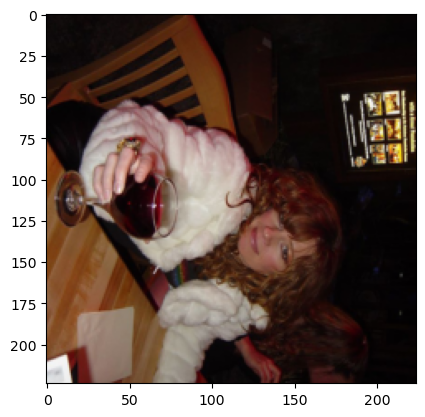

In [346]:
idx = 5
bbo = one_batch[1][idx]
ima = one_batch[0][idx].permute(2,1,0)

plt.imshow(ima)

In [347]:
x = one_batch[0]
x.shape

torch.Size([64, 3, 224, 224])

In [348]:
y = one_batch[1:]
y[0].shape, y[1].shape

(torch.Size([64, 11, 4]), torch.Size([64, 11]))

In [349]:
x = one_batch[0].permute(0,3,2,1)
y = one_batch[1:]

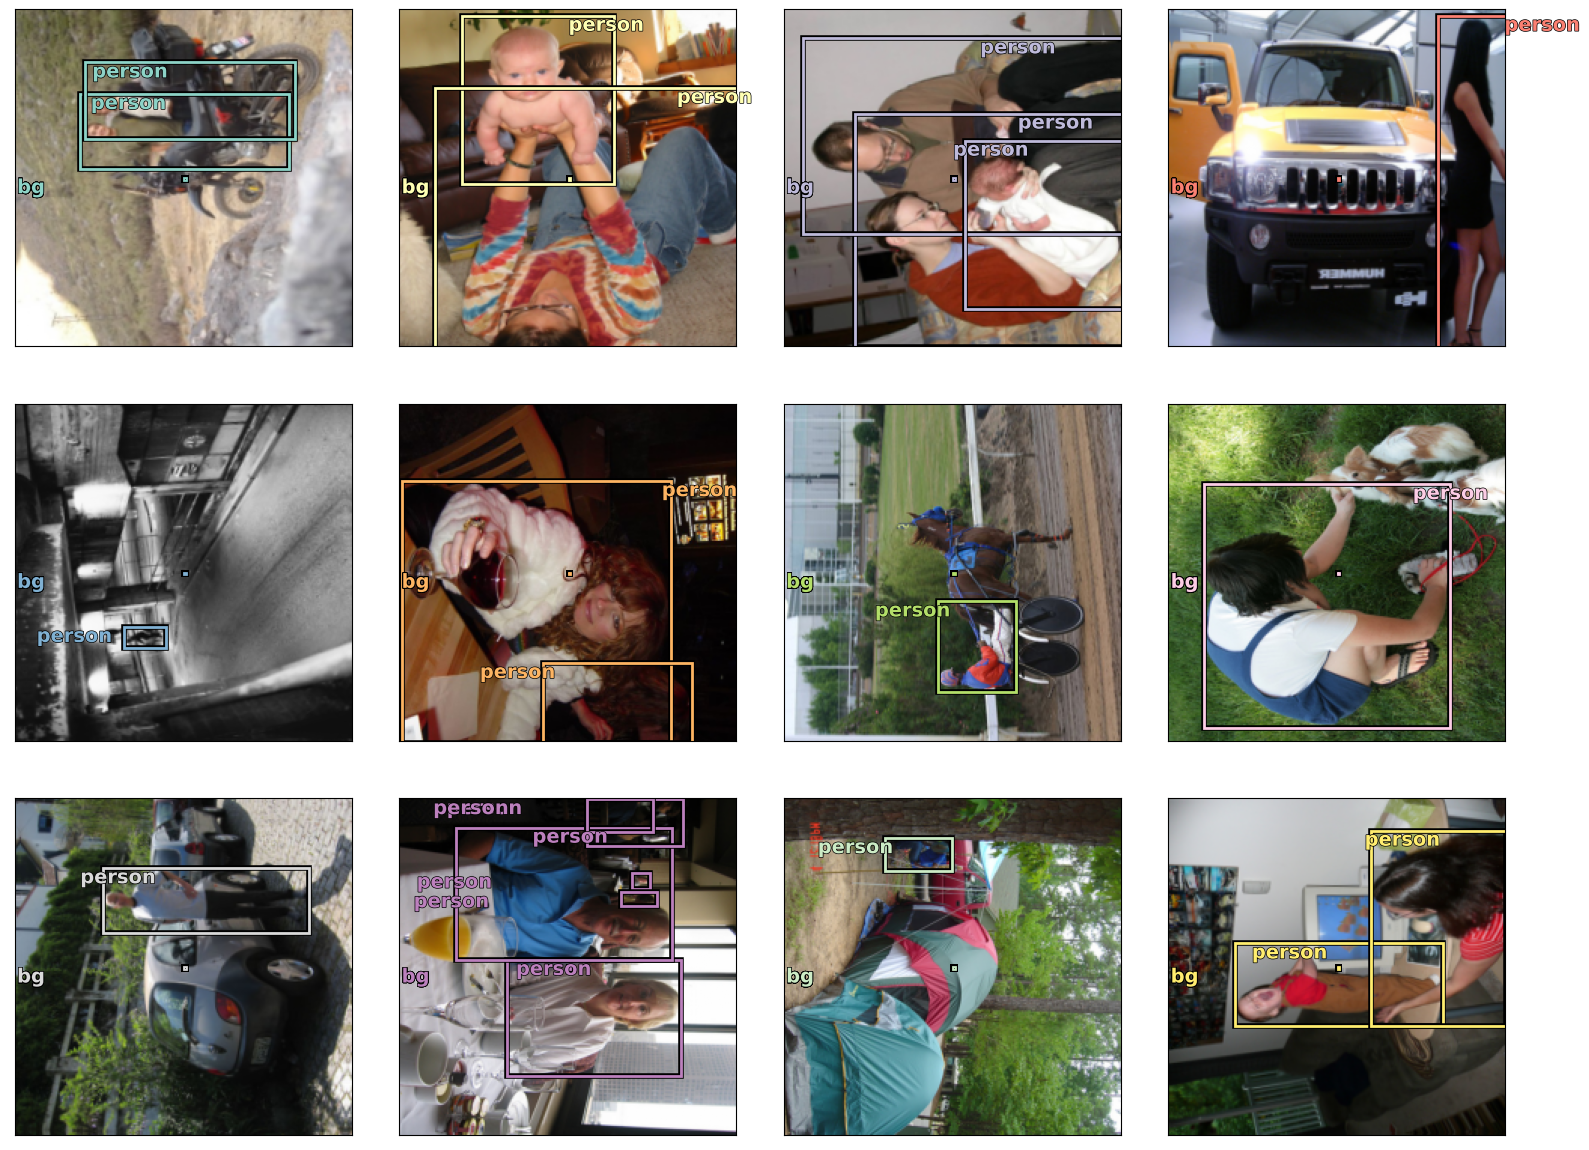

In [350]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    torch_gt(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [303]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    clas = clas.view(-1,1)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return TensorBase(bbox)[bb_keep],TensorBase(clas)[bb_keep]

In [304]:
def hw2corners(ctr, hw):
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [305]:
def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [306]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [307]:
def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

In [308]:
def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [309]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1) # 3
    gt_overlap, gt_idx = overlaps.max(0) # 16
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [310]:
def ssd_1_loss(b_c,b_bb,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    bbox = (bbox+1)/2
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0  # Assign the background to idx 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((TensorBase(a_ic[TensorBase(pos_idx)]) - TensorBase(gt_bbox[TensorBase(pos_idx)])).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

In [311]:
anc_grid = 4
k = 1
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) 
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid) 

In [312]:
anc_x, anc_y

(array([0.125, 0.125, 0.125, 0.125, 0.375, 0.375, 0.375, 0.375, 0.625,
        0.625, 0.625, 0.625, 0.875, 0.875, 0.875, 0.875]),
 array([0.125, 0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875, 0.125,
        0.375, 0.625, 0.875, 0.125, 0.375, 0.625, 0.875]))

In [313]:
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1)) # Anchor centers
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])

In [314]:
anc_ctrs, anc_sizes

(array([[0.125, 0.125],
        [0.125, 0.375],
        [0.125, 0.625],
        [0.125, 0.875],
        [0.375, 0.125],
        [0.375, 0.375],
        [0.375, 0.625],
        [0.375, 0.875],
        [0.625, 0.125],
        [0.625, 0.375],
        [0.625, 0.625],
        [0.625, 0.875],
        [0.875, 0.125],
        [0.875, 0.375],
        [0.875, 0.625],
        [0.875, 0.875]]),
 array([[0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.25]]))

In [315]:
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False)

In [316]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], dtype=torch.float64)

In [317]:
grid_sizes = torch.tensor(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

In [318]:
grid_sizes

tensor([[0.2500]], dtype=torch.float64)

In [319]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [320]:
bbox = one_batch[1][idx]
clas = one_batch[2][idx]
bbox, clas

(TensorBBox([[-0.5413, -1.0000,  1.0000,  0.6080],
             [ 0.5360, -0.1600,  1.0000,  0.7360],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000],
             [ 0.0000,  0.0000,  0.0000,  0.0000]]),
 TensorMultiCategory([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [321]:
bbox,clas = get_y(bbox,clas)
bbox = (bbox+1)/2
bbox, clas

(TensorBBox([[0.2293, 0.0000, 1.0000, 0.8040],
             [0.7680, 0.4200, 1.0000, 0.8680]]),
 TensorBBox([[1],
             [1]]))

In [322]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps

TensorBBox([[0.0076, 0.0076, 0.0076, 0.0016, 0.1009, 0.1009, 0.1009, 0.0202,
             0.1009, 0.1009, 0.1009, 0.0202, 0.1009, 0.1009, 0.1009, 0.0202],
            [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
             0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1255, 0.5349, 0.1969]],
           dtype=torch.float64)

In [323]:
overlaps.max(1)

torch.return_types.max(
values=TensorBBox([0.1009, 0.5349], dtype=torch.float64),
indices=TensorBBox([ 4, 14]))

In [324]:
overlaps.max(0)

torch.return_types.max(
values=TensorBBox([0.0076, 0.0076, 0.0076, 0.0016, 0.1009, 0.1009, 0.1009, 0.0202,
            0.1009, 0.1009, 0.1009, 0.0202, 0.1009, 0.1255, 0.5349, 0.1969],
           dtype=torch.float64),
indices=TensorBBox([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]))

In [325]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(TensorBBox([7.6323e-03, 7.6323e-03, 7.6323e-03, 1.6388e-03, 1.9900e+00,
             1.0087e-01, 1.0087e-01, 2.0191e-02, 1.0087e-01, 1.0087e-01,
             1.0087e-01, 2.0191e-02, 1.0087e-01, 1.2551e-01, 1.9900e+00,
             1.9686e-01], dtype=torch.float64),
 TensorBBox([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]))

In [326]:
clas

TensorBBox([[1],
            [1]])

In [327]:
gt_clas = gt_idx
gt_clas

TensorBBox([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [328]:
pos = gt_overlap > 0.4
pos_idx = torch.nonzero(pos)[:,0]
pos_idx

TensorBBox([ 4, 14])

In [329]:
cat=["bg", "person"]
[cat[0] if (i!=pos_idx[0] and i!=pos_idx[1]) else cat[1] for i,_ in enumerate(gt_clas)]

['bg',
 'bg',
 'bg',
 'bg',
 'person',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'person',
 'bg']

In [330]:
bbox

TensorBBox([[0.2293, 0.0000, 1.0000, 0.8040],
            [0.7680, 0.4200, 1.0000, 0.8680]])

In [331]:
gt_idx

TensorBBox([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [332]:
gt_bbox = bbox[gt_idx]
gt_bbox

TensorBBox([[0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.2293, 0.0000, 1.0000, 0.8040],
            [0.7680, 0.4200, 1.0000, 0.8680],
            [0.7680, 0.4200, 1.0000, 0.8680],
            [0.7680, 0.4200, 1.0000, 0.8680]])

In [333]:
ima = one_batch[0][idx].permute(2,1,0).cpu()

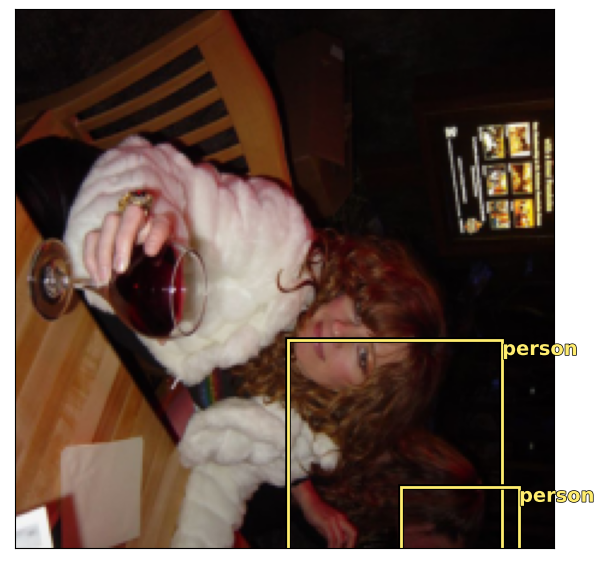

In [341]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

In [259]:
ima.size()

torch.Size([224, 224, 3])

In [275]:
anchor_cnr, gt_clas

(tensor([[0.0000, 0.0000, 0.2500, 0.2500],
         [0.0000, 0.2500, 0.2500, 0.5000],
         [0.0000, 0.5000, 0.2500, 0.7500],
         [0.0000, 0.7500, 0.2500, 1.0000],
         [0.2500, 0.0000, 0.5000, 0.2500],
         [0.2500, 0.2500, 0.5000, 0.5000],
         [0.2500, 0.5000, 0.5000, 0.7500],
         [0.2500, 0.7500, 0.5000, 1.0000],
         [0.5000, 0.0000, 0.7500, 0.2500],
         [0.5000, 0.2500, 0.7500, 0.5000],
         [0.5000, 0.5000, 0.7500, 0.7500],
         [0.5000, 0.7500, 0.7500, 1.0000],
         [0.7500, 0.0000, 1.0000, 0.2500],
         [0.7500, 0.2500, 1.0000, 0.5000],
         [0.7500, 0.5000, 1.0000, 0.7500],
         [0.7500, 0.7500, 1.0000, 1.0000]], dtype=torch.float64),
 TensorBBox([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]))

In [281]:
w=((anchor_cnr[0]+1)/2*224).long()
w

tensor([112, 112, 140, 140])

In [283]:
r = bb_hw(to_np(w))
r

array([112, 140, -27,  29])

In [276]:
bb_hw(to_np((((anchor_cnr[0]+1)/2*224).long())))

array([112, 140, -27,  29])

In [293]:
[bb_hw(to_np(((a*224).long()))) for a in anchor_cnr]

[array([  0,  56, -55,  57]),
 array([  0, 112, -55,  57]),
 array([  0, 168, -55,  57]),
 array([  0, 224, -55,  57]),
 array([ 56,  56, -55,  57]),
 array([ 56, 112, -55,  57]),
 array([ 56, 168, -55,  57]),
 array([ 56, 224, -55,  57]),
 array([112,  56, -55,  57]),
 array([112, 112, -55,  57]),
 array([112, 168, -55,  57]),
 array([112, 224, -55,  57]),
 array([168,  56, -55,  57]),
 array([168, 112, -55,  57]),
 array([168, 168, -55,  57]),
 array([168, 224, -55,  57])]

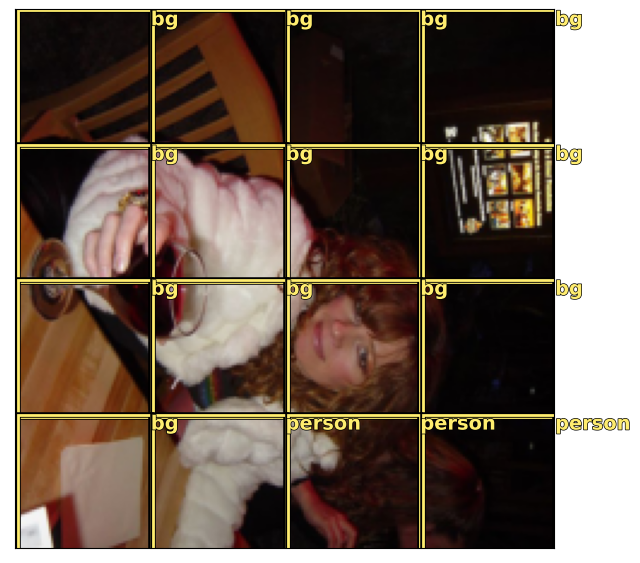

In [335]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax=ax, ima=ima, bbox=anchor_cnr, s = False, clas=gt_clas)